## Optimizing case definitions
Public health case definitions often take the form of predictive checklists, like "if the person has 2 or more of the following 5 symptoms, then he or she is a probable case". Case definitions can be built by hand, e.g., by using published data and expert intuition to design them from scratch, but they can also be built automatically. This notebook provides a brief overview of the latter, as enabled by the `kudos` Python package.

### Checking the performance of the original predictors
Before trying to find optimal combinations of symptoms, it's often helpful to look at the performance of each symptom individually. Let's load the test data we have in the repository and see what predictors we have to work with.

In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns

from matplotlib import pyplot as plt
from importlib import reload

from kudos import optimizers as ops
from kudos import metrics, tools

In [2]:
records = pd.read_csv('data/stroke_data.csv')
records.head()

,stroke,high_cholesterol,drug_use,smoking,heart_failure,alcohol_use,diabetes,high_rbc,sedentary,abpain,family_hist,arrhythmia,tias,high_bp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,0,1,1,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Here, we have some synthetic data about a particular outcome (`stroke`) and some of its predictors (the rest of the columns). Let's see how strongly each of the individual predictors is associated with the outcome. 

In [4]:
y = records.stroke.values
X = records.iloc[:, records.columns != 'stroke']

single_stats = pd.concat([metrics.clf_metrics(y, X[c], mod_name=c) for c in X.columns.values])
single_stats.columns.values[0] = 'symptom'
single_stats.sort_values('j', ascending=False)

,symptom,tp,fp,tn,fn,sens,spec,ppv,npv,j,f1,mcc,brier,auc,ap,true_prev,pred_prev,prev_diff,rel_prev_diff
0,high_bp,158.0,485.0,1327.0,30.0,0.8404,0.7323,0.2457,0.9779,0.5727,0.3802,0.357882,0.2575,0,0,188.0,643.0,455.0,2.4202
0,high_rbc,143.0,384.0,1428.0,45.0,0.7606,0.7881,0.2713,0.9695,0.5487,0.3999,0.363497,0.2145,0,0,188.0,527.0,339.0,1.8032
0,sedentary,124.0,322.0,1490.0,64.0,0.6596,0.8223,0.2780,0.9588,0.4819,0.3911,0.337828,0.1930,0,0,188.0,446.0,258.0,1.3723
0,heart_failure,115.0,236.0,1576.0,73.0,0.6117,0.8698,0.3276,0.9557,0.4815,0.4267,0.369363,0.1545,0,0,188.0,351.0,163.0,0.8670
0,drug_use,105.0,259.0,1553.0,83.0,0.5585,0.8571,0.2885,0.9493,0.4156,0.3805,0.314315,0.1710,0,0,188.0,364.0,176.0,0.9362
0,smoking,109.0,334.0,1478.0,79.0,0.5798,0.8157,0.2460,0.9493,0.3955,0.3454,0.277917,0.2065,0,0,188.0,443.0,255.0,1.3564
0,high_cholesterol,82.0,195.0,1617.0,106.0,0.4362,0.8924,0.2960,0.9385,0.3286,0.3527,0.277576,0.1505,0,0,188.0,277.0,89.0,0.4734
0,tias,47.0,56.0,1756.0,141.0,0.2500,0.9691,0.4563,0.9257,0.2191,0.3230,0.289293,0.0985,0,0,188.0,103.0,-85.0,-0.4521
0,diabetes,47.0,92.0,1720.0,141.0,0.2500,0.9492,0.3381,0.9242,0.1992,0.2875,0.228626,0.1165,0,0,188.0,139.0,-49.0,-0.2606
0,family_hist,39.0,139.0,1673.0,149.0,0.2074,0.9233,0.2191,0.9182,0.1307,0.2131,0.133989,0.1440,0,0,188.0,178.0,-10.0,-0.0532


That's a lot of numbers! Focusing on Youden's J index (`j`), though, which is a good overall measure of classification performance, shows that there are a number of strong predictors, including hyptertension (`high_bp`), high red blood cell count (`high_rbc`), and sedentary lifestyle (`sedentary`). Picking hypertension alone would have decent performance as a screening rule (sensitivity and specificity are 84% and 73%, respectively), but let's see if we can do better by looking at combinations of the predictors.

## Examining simple combinations
`kudos` implements three main methods for evaluating simple combinations of symptoms (or other kinds of predictors): an integer program, a nonlinear approximation to an integer program, and a brute-force combinatorial search. Since the integer program is guaranteed to find the best solution, let's start there.

In [5]:
ip = ops.IntegerProgram()
ip.fit(X, y)

Objective value = 527.0
Problem solved in 3767.000000 milliseconds
Problem solved in 0 iterations
Problem solved in 0 branch-and-bound nodes


Notice how easy it is to fit the optimizer--all you need to do is pass the predictors as a `pd.DataFrame` to the .fit() method, along with the outcome as an `np.array`, and it will find the (again, guaranteed optimal) solution for you. Let's see what it was by checking the `optimizer.results` object.

In [6]:
ip.results

,m1,rule1,n1,sens,spec,j
0,1,high_cholesterol drug_use heart_failure alcoho...,6,0.962766,0.747792,0.710558


We can see that Youden's J index has moved up to 0.71 from 0.57--not bad! Relative to `high_bp`, we gained a little specificity, and we gained a ton of sensitivity, such that the new rule only has a 4% false-negative rate. What *is* the new rule, though? Since this results format is used for the other optimizers, let's take a second to see how we can use the column names of the results object to reconstruct a plain-language case definition.

In [7]:
best_simple = tools.rule_df_to_str(ip.results)
best_simple

'At least 1 of (high_cholesterol drug_use heart_failure alcohol_use high_rbc family_hist)'

Cool. So we can see that, in the `ip.results` DataFrame, `m1` is the minimum number of symptoms the person must have, and `rule1` is the collection of symptoms. The third column, `n1`, specifies the total number of symptoms under consideration in this particular combination. Each of these has a `1` at the end because, as we'll see later, some of the optimizers also let you search for compound combinations, or combinations of simple rules, and so there will be two sets of `m` values, `n` values, and `rule` strings.

The other two optimizers, `NonlinearApproximation` and `FullEnumeration`, will also work for simple combinations. Let's start with the nonlinear approximation and see how it does.

In [8]:
nola = ops.NonlinearApproximation()
nola.fit(X, y)
nola.results

,m1,rule1,n1,sens,spec,j
0,2.0,high_cholesterol drug_use heart_failure alcoho...,7,0.87234,0.772075,0.644415


So the runtime here was super fast--less than a second!--but we can see that with a J of 0.64, the solution is not as good as the optimum found by the integer program (both are mathematically set to optimize J). This is the downside to the nonlinear approximation--the math it uses to approximate the integer program runs fast, but it's not guaranteed to be optimal (or even close).

Finally, let's try the brute-force approach. As long as we don't limit the maximum number of symptoms `n` in any candidate combination, it should recover the solution from the integer program, along with many others.

In [9]:
fe = ops.FullEnumeration()
fe.fit(X, y, max_n=6, verbose=False)

In [10]:
fe.results

,m1,rule1,link,m2,rule2,n1,n2,sens,spec,j,total_n
0,1,high_cholesterol drug_use heart_failure alcoho...,,0,,6,0,0.962766,0.747792,0.710558,6
1,1,high_cholesterol drug_use alcohol_use diabetes...,,0,,6,0,0.941489,0.767108,0.708598,6
2,1,high_cholesterol drug_use heart_failure alcoho...,,0,,5,0,0.957447,0.751104,0.708551,5
3,1,high_cholesterol drug_use heart_failure alcoho...,,0,,6,0,0.957447,0.750000,0.707447,6
4,1,high_cholesterol drug_use heart_failure alcoho...,,0,,6,0,0.957447,0.749448,0.706895,6
...,...,...,...,...,...,...,...,...,...,...,...
20613,4,high_cholesterol alcohol_use abpain family_his...,,0,,5,0,0.000000,0.987307,-0.012693,5
20614,4,alcohol_use high_rbc abpain family_hist arrhyt...,,0,,5,0,0.000000,0.987307,-0.012693,5
20615,3,sedentary abpain family_hist,,0,,3,0,0.000000,0.986755,-0.013245,3
20616,4,alcohol_use sedentary abpain family_hist arrhy...,,0,,5,0,0.000000,0.986203,-0.013797,5


There we go! Crunching through all of the potential combinations recovered the optimal solution from before, and it also got us all of the other ones (all 20,617) of them. Having the full enumeration is reassuring in that it confirms the solution from the integer program, but it also lets us do two important things:

1. Visualize the distribution of metrics for all the combinations; and
2. Pick our "top" combination by examining criteria other than just the metric that was optimized.

Visualization is straightforward and is handled by the `FullEnumeration.plot()` function. Since we optimized `j`, let's look at the candidate combinations as points in ROC space.

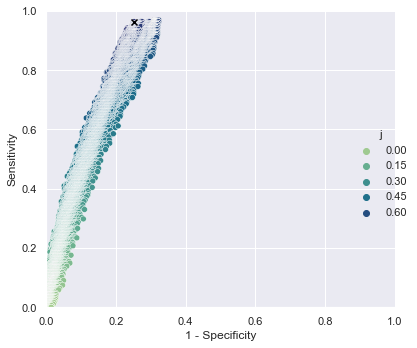

In [11]:
fe.plot()

Not very exciting, but nice if you want to get a sense for how much variability there was in the combinations' performance. We can also do a panel plot that sorts the combinations by the total number of symptoms they considered (`total_n` in the `results` object).

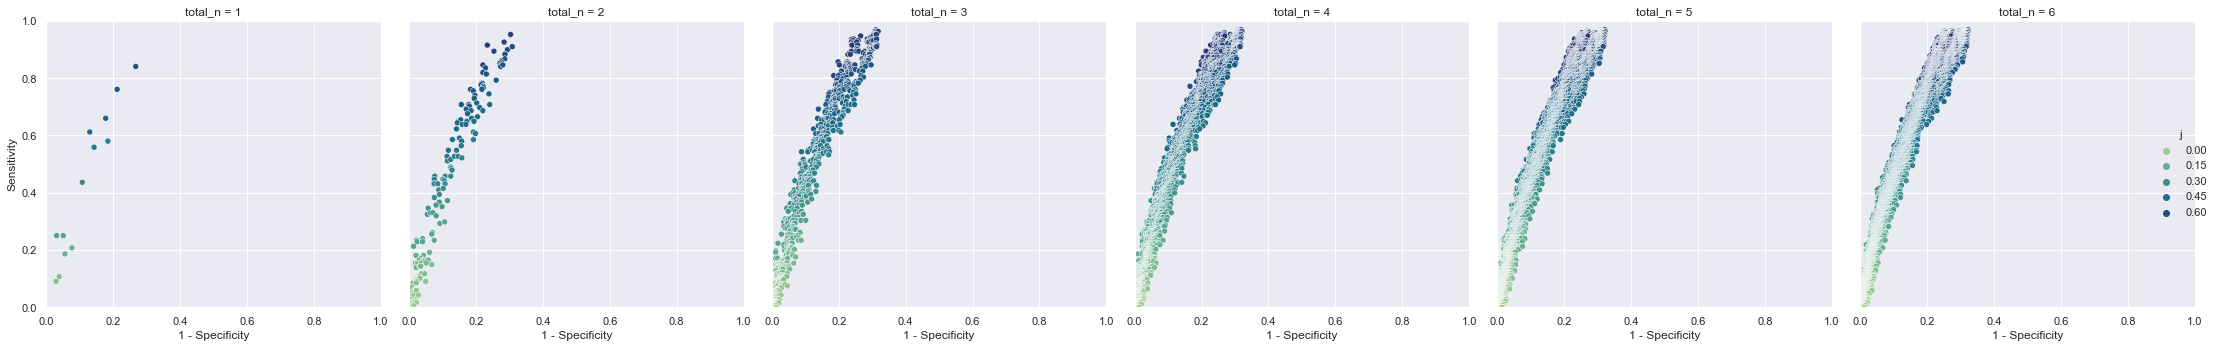

In [12]:
fe.plot(separate_n=True)

Again, these aren't very exciting, partly because the symptoms in our test data are synthetic and have less variability than they might if they were real, but they're still handy.

